<a href="https://colab.research.google.com/github/kchaitanya954/Machine-learning-technologies/blob/main/ML_course_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import soundfile
import os, glob, pickle
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [12]:
# mountiong the drive
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [13]:
# Load the train data
audio_path='/content/drive/My Drive/Colab Notebooks/audio data/*'


In [14]:
# to access file names to get the information about the emotions
import os
mylist= os.listdir(audio_path[:-1])

In [15]:
# To access the 1440 audio files
import glob
audio_files = glob.glob(audio_path)

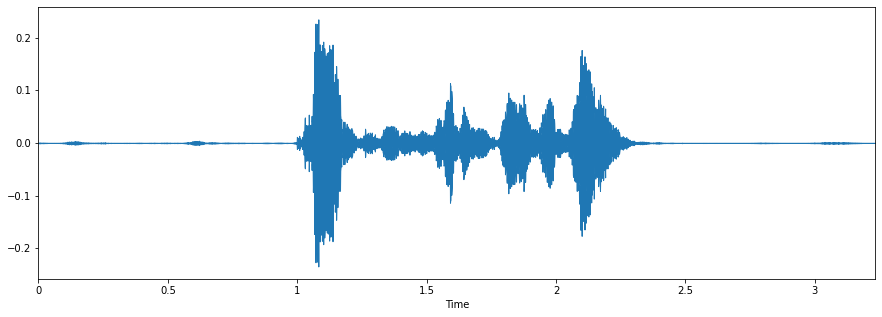

In [16]:
data, sampling_rate = librosa.load(audio_files[90])
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [17]:
#DataFlair - Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised',
   'n':'calm',
   'h':'happy',
  'sa':'sad',
   'a':'angry',
   'f':'fearful',
   'd':'disgust',
  'su':'surprised'
}

#DataFlair - Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [18]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X, sample_rate = librosa.load(file_name)
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [21]:
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob(audio_path):
        file_name=os.path.basename(file)
        if file_name[0]=='s':
            emotion=emotions[file_name[:2]]
        elif (file_name[0]=='n' or file_name[0]=='d' or file_name[0]=='a' or file_name[0]=='f' or file_name[0]=='h'):
            emotion=emotions[file_name[0]]
        else:            
            emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [22]:
x_train,x_test,y_train,y_test=load_data(test_size=0.2)

In [25]:
print((x_train.shape[0], x_test.shape[0]))
#DataFlair - Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

(794, 199)
Features extracted: 180


In [26]:
#DataFlair - Initialize the Multi Layer Perceptron Classifier
model_mlp=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [27]:
#DataFlair - Train the model
model_mlp.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [28]:
#DataFlair - Predict for the test set
y_pred=model_mlp.predict(x_test)
#DataFlair - Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#DataFlair - Print the accuracy
print("Accuracy using MLP: {:.2f}%".format(accuracy*100))

Accuracy using MLP: 61.31%


In [29]:
from sklearn import svm
clf_svm = svm.NuSVC(gamma='auto')
clf_svm.fit(x_train, y_train)
#DataFlair - Predict for the test set
y_pred_svm=clf_svm.predict(x_test)
#DataFlair - Calculate the accuracy of our model
accuracy_svm=accuracy_score(y_true=y_test, y_pred=y_pred_svm)

#DataFlair - Print the accuracy
print("Accuracy using SVM: {:.2f}%".format(accuracy_svm*100))

Accuracy using SVM: 66.83%


In [30]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=int(x_train.shape[0]**0.5))
clf_knn.fit(x_train, y_train)
#DataFlair - Predict for the test set
y_pred_knn=clf_knn.predict(x_test)
#DataFlair - Calculate the accuracy of our model
accuracy_knn=accuracy_score(y_true=y_test, y_pred=y_pred_knn)

#DataFlair - Print the accuracy
print("Accuracy using KNN: {:.2f}%".format(accuracy_knn*100))

Accuracy using KNN: 54.27%


In [31]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder


lb = LabelEncoder()

y_train_en = np_utils.to_categorical(lb.fit_transform(y_train))
y_test_en = np_utils.to_categorical(lb.fit_transform(y_test))

In [32]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)

In [33]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(180,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(4))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 180, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 180, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 180, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 180, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 180, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 22, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 128)           8

In [34]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])


In [35]:
cnnhistory=model.fit(x_traincnn, y_train_en, batch_size=16, epochs=500, validation_data=(x_testcnn, y_test_en))


Epoch 1/500
50/50 [==============================] - 6s 102ms/step - loss: 2.8631 - accuracy: 0.2680 - val_loss: 1.3707 - val_accuracy: 0.2864
Epoch 2/500
50/50 [==============================] - 5s 96ms/step - loss: 1.5068 - accuracy: 0.3597 - val_loss: 1.3393 - val_accuracy: 0.3618
Epoch 3/500
50/50 [==============================] - 5s 96ms/step - loss: 1.5984 - accuracy: 0.2907 - val_loss: 1.3389 - val_accuracy: 0.4020
Epoch 4/500
50/50 [==============================] - 5s 97ms/step - loss: 1.5837 - accuracy: 0.3054 - val_loss: 1.2956 - val_accuracy: 0.4221
Epoch 5/500
50/50 [==============================] - 5s 97ms/step - loss: 1.4910 - accuracy: 0.3205 - val_loss: 1.3079 - val_accuracy: 0.3518
Epoch 6/500
50/50 [==============================] - 5s 99ms/step - loss: 1.4742 - accuracy: 0.3311 - val_loss: 1.2921 - val_accuracy: 0.4070
Epoch 7/500
50/50 [==============================] - 5s 98ms/step - loss: 1.4300 - accuracy: 0.3339 - val_loss: 1.2647 - val_accuracy: 0.4070
Epoch

In [36]:
cnnhistory.history['val_accuracy'][-1]

0.6984924674034119

In [37]:
print("Accuracy using CNN: {:.2f}%".format(cnnhistory.history['val_accuracy'][-1]*100))

Accuracy using CNN: 69.85%


In [38]:
# Training data using dence eural networks
model_ann = Sequential()
model_ann.add(Dense(256, activation='relu', input_shape=(180,1)))
model_ann.add(Dense(128, activation='relu'))
model_ann.add(Dense(64, activation='relu'))
model_ann.add(Flatten())
model_ann.add(Dense(4, activation='softmax'))
model_ann.add(Activation('softmax'))

opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model_ann.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_ann.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 180, 256)          512       
_________________________________________________________________
dense_2 (Dense)              (None, 180, 128)          32896     
_________________________________________________________________
dense_3 (Dense)              (None, 180, 64)           8256      
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 46084     
_________________________________________________________________
activation_5 (Activation)    (None, 4)                 0         
Total params: 87,748
Trainable params: 87,748
Non-trainable params: 0
__________________________________________________

In [39]:
ann_history = model_ann.fit(x_traincnn, y_train_en, epochs=600, batch_size=16, validation_data=(x_testcnn, y_test_en))

Epoch 1/600
50/50 [==============================] - 3s 32ms/step - loss: 1.4158 - accuracy: 0.1904 - val_loss: 1.3772 - val_accuracy: 0.2613
Epoch 2/600
50/50 [==============================] - 1s 27ms/step - loss: 1.3858 - accuracy: 0.2622 - val_loss: 1.3661 - val_accuracy: 0.2915
Epoch 3/600
50/50 [==============================] - 1s 27ms/step - loss: 1.3760 - accuracy: 0.2738 - val_loss: 1.3557 - val_accuracy: 0.3568
Epoch 4/600
50/50 [==============================] - 1s 27ms/step - loss: 1.3726 - accuracy: 0.3019 - val_loss: 1.3480 - val_accuracy: 0.3719
Epoch 5/600
50/50 [==============================] - 1s 26ms/step - loss: 1.3610 - accuracy: 0.3303 - val_loss: 1.3422 - val_accuracy: 0.3719
Epoch 6/600
50/50 [==============================] - 1s 27ms/step - loss: 1.3479 - accuracy: 0.3535 - val_loss: 1.3346 - val_accuracy: 0.3769
Epoch 7/600
50/50 [==============================] - 1s 26ms/step - loss: 1.3523 - accuracy: 0.3196 - val_loss: 1.3249 - val_accuracy: 0.3719
Epoch 

In [41]:
ann_history.history['val_accuracy'][-1]

0.6281406879425049

In [42]:
print("Accuracy using DNN: {:.2f}%".format(ann_history.history['val_accuracy'][-1]*100))

Accuracy using DNN: 62.81%
